<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   case_created                 500 non-null    object
 1   issue_category               500 non-null    object
 2   issue_type                   500 non-null    object
 3   language                     500 non-null    object
 4   csat_rating_rate             500 non-null    int64 
 5   channel                      500 non-null    object
 6   count of outbound responses  500 non-null    int64 
 7   first_reply_within_sla       500 non-null    bool  
 8   resolution_time_in_mins      500 non-null    int64 
dtypes: bool(1), int64(3), object(5)
memory usage: 31.9+ KB
   year  case_count
0  2023         243
1  2024         257
   month  case_count
0      1          75
1      2          94
2      3          88
3      9          54
4     10          52
5     11          70
6 

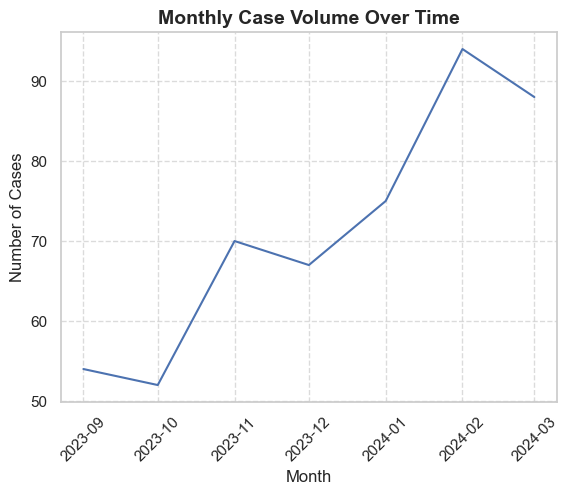

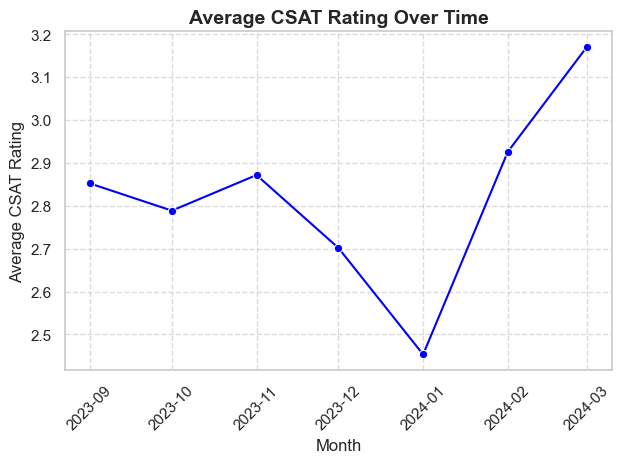

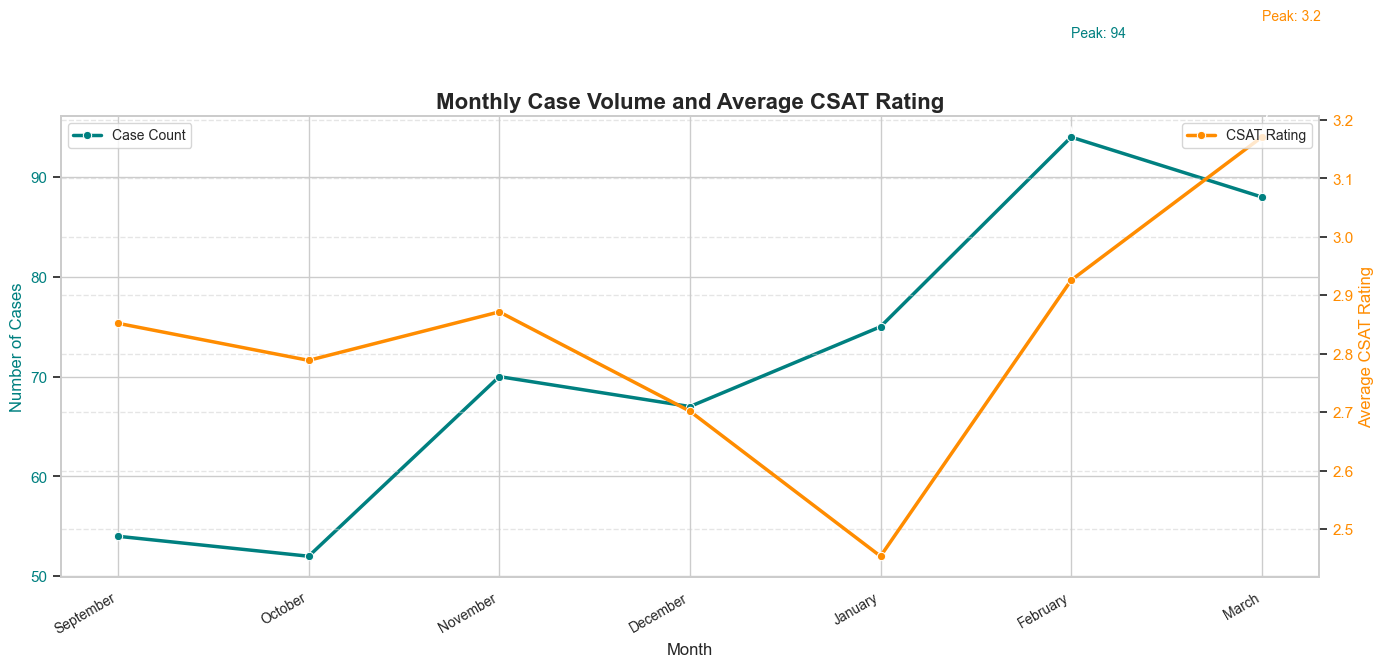

     issue_type  case_count  avg_csat_rating  max_resolution_time  \
0    Resolvable         182             3.21                29986   
1  Unresolvable         318             2.62                73251   

   min_resolution_time  avg_resolution_time  total_outbound_responses  \
0                    6               890.16                       0.0   
1                    4               674.19                       0.0   

   sla_met_count  distinct_languages  
0            161                  10  
1            292                  17  


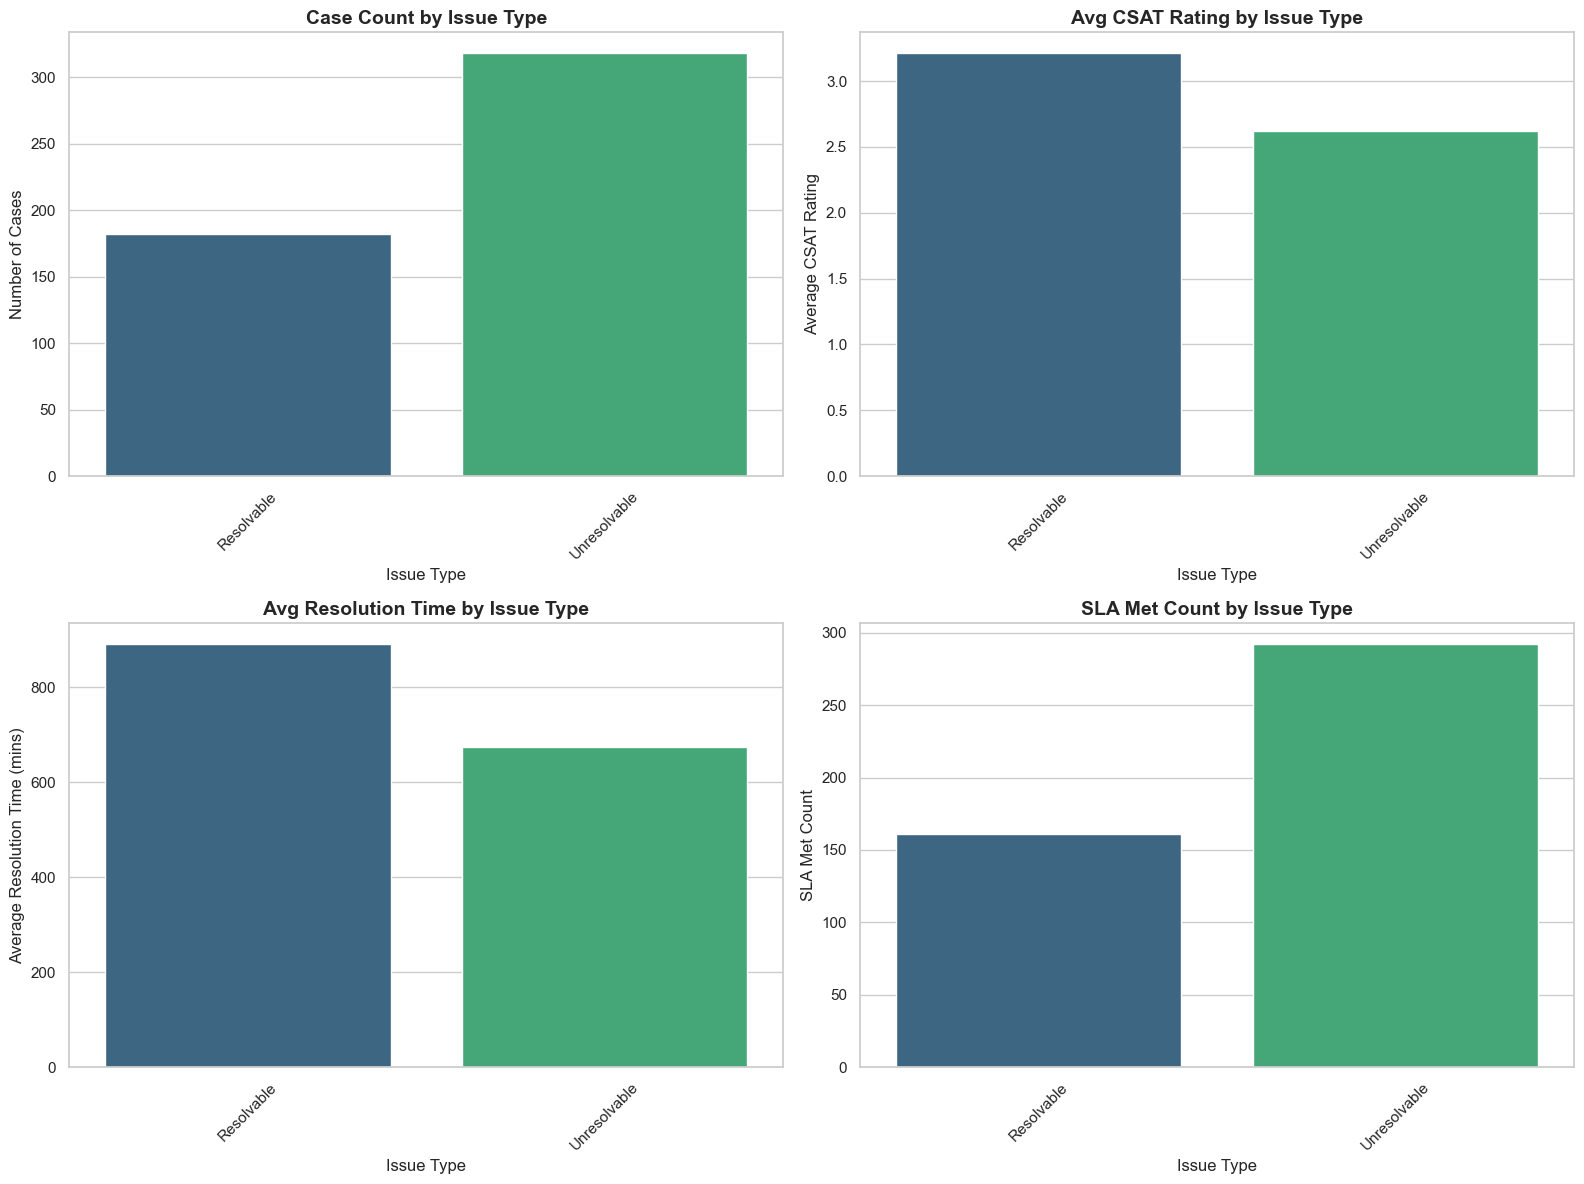

   first_reply_within_sla  avg_csat_rating  case_count
0                       0             2.96          47
1                       1             2.83         453
Correlation between SLA Met and CSAT Rating: -0.02


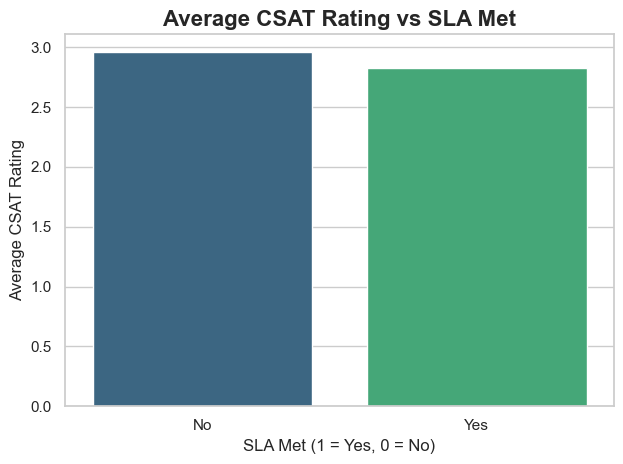

     issue_type  avg_csat_rating  case_count  max_csat_rating  \
0  Unresolvable             2.62         318                5   
1    Resolvable             3.21         182                5   

   min_csat_rating  avg_resolution_time  
0                1               674.19  
1                1               890.16  


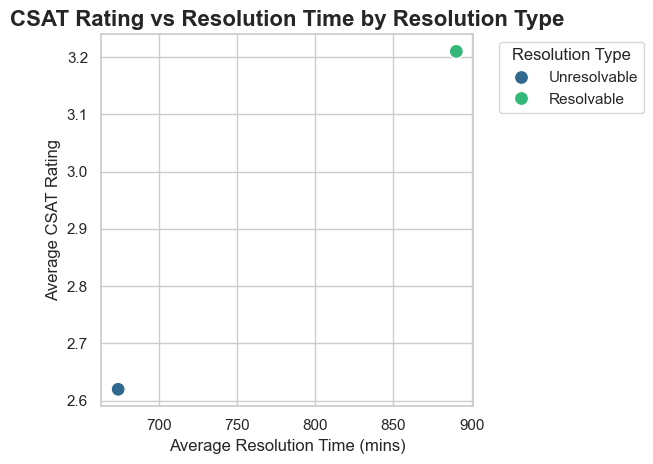

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Load the dataset

df = pd.read_csv(
    "Data/stripe_csat.csv"
)
# Display basic information about the dataset

df.head()
df.tail()
df.info()
df.describe().round(2)
df.columns
# Convert the 'created_at' column to datetime

df["case_created"] = pd.to_datetime(df["case_created"])
# Rename columns for consistency and removing whitespaces 

df.rename(columns={"count of outbound responses": "count_of_outbound_responses"}, inplace=True)
# Extract the year, month, day, and day of the week from the 'created_at' column

df["year"] = df["case_created"].dt.year
df["month"] = df["case_created"].dt.month
df["day"] = df["case_created"].dt.day
df["day_of_week"] = df["case_created"].dt.dayofweek
# Connect to SQLite database

conn = sqlite3.connect("stripe_case_study.db")  # Create SQLite database
df.to_sql(
    "cases", conn, if_exists="replace", index=False
)
# Query the database to get the number of cases created each year

query = "SELECT year, COUNT(*) as case_count FROM cases GROUP BY year"
yearly_cases = pd.read_sql_query(query, conn)
print(yearly_cases)
# Query the database to get the number of cases created each month

query = "SELECT month, COUNT(*) as case_count FROM cases GROUP BY month"
monthly_cases = pd.read_sql_query(query, conn)
print(monthly_cases)
# Visualize the number of cases created each month

query = """
SELECT strftime('%Y-%m', case_created) as month, COUNT(*) as case_count
FROM cases
GROUP BY month
ORDER BY month
"""

monthly_data = pd.read_sql_query(query, conn)
monthly_data["month"] = pd.to_datetime(monthly_data["month"])
# Plot aggregated data

sns.set_theme(style="whitegrid")  # Set a clean theme
sns.lineplot(data=monthly_data, x="month", y="case_count")
plt.title("Monthly Case Volume Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Number of Cases", fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.7)  # Add gridlines
plt.xticks(rotation=45)
plt.show()
# Query the database to get the number of cases created each month and the average csat_score

query_csat = """
SELECT strftime('%Y-%m', case_created) as month, 
    AVG(csat_rating_rate) as avg_csat_rating
FROM cases
GROUP BY month
ORDER BY month
"""

csat_data = pd.read_sql_query(query_csat, conn)
# Convert 'month' to datetime

csat_data["month"] = pd.to_datetime(csat_data["month"], format="%Y-%m", errors="coerce")
# Plot the average CSAT rating over time

sns.set_theme(style="whitegrid")
sns.lineplot(data=csat_data, x="month", y="avg_csat_rating", marker="o", color="blue")
plt.title("Average CSAT Rating Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average CSAT Rating", fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Query for monthly case count

query_cases = """
SELECT strftime('%Y-%m', case_created) as month, 
       COUNT(*) as case_count 
FROM cases 
GROUP BY month 
ORDER BY month
"""

monthly_cases = pd.read_sql_query(query_cases, conn)
monthly_cases["month"] = pd.to_datetime(monthly_cases["month"], format='%Y-%m')
# Query for average CSAT rating

query_csat = """
SELECT strftime('%Y-%m', case_created) as month, 
       AVG(csat_rating_rate) as avg_csat_rating 
FROM cases 
GROUP BY month 
ORDER BY month
"""

monthly_csat = pd.read_sql_query(query_csat, conn)
monthly_csat["month"] = pd.to_datetime(monthly_csat["month"], format='%Y-%m')
# Merge the two datasets on the 'month' column

monthly_data = pd.merge(monthly_cases, monthly_csat, on="month")
# Format 'month' column to show full month names

monthly_data['month_name'] = monthly_data['month'].dt.strftime('%B')
# Plot the data

sns.set_theme(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))  # Increase figure size for better readability
# Line plot for case count

color1 = "teal"
sns.lineplot(data=monthly_data, x="month_name", y="case_count", marker="o", color=color1, linewidth=2.5, ax=ax1, label="Case Count")
ax1.set_ylabel("Number of Cases", fontsize=12, color=color1)
ax1.tick_params(axis="y", labelcolor=color1)
ax1.set_xlabel("Month", fontsize=12)
# Line plot for average CSAT rating

ax2 = ax1.twinx()  # Create a secondary y-axis
color2 = "darkorange"
sns.lineplot(data=monthly_data, x="month_name", y="avg_csat_rating", marker="o", color=color2, linewidth=2.5, ax=ax2, label="CSAT Rating")
ax2.set_ylabel("Average CSAT Rating", fontsize=12, color=color2)
ax2.tick_params(axis="y", labelcolor=color2)
# Add a title

plt.title("Monthly Case Volume and Average CSAT Rating", fontsize=16, fontweight="bold")
# Add legends for both metrics

ax1.legend(loc="upper left", fontsize=10)
ax2.legend(loc="upper right", fontsize=10)
# Adjust gridlines

plt.grid(visible=True, linestyle="--", alpha=0.5)
# Improve x-axis labels

ax1.set_xticks(range(len(monthly_data["month_name"])))
ax1.set_xticklabels(monthly_data["month_name"], rotation=30, ha="right", fontsize=10)
# Annotate key points (optional)

max_case_point = monthly_data.loc[monthly_data["case_count"].idxmax()]
max_csat_point = monthly_data.loc[monthly_data["avg_csat_rating"].idxmax()]
ax1.annotate(f"Peak: {max_case_point['case_count']}", 
             xy=(max_case_point["month_name"], max_case_point["case_count"]),
             xytext=(max_case_point["month_name"], max_case_point["case_count"] + 10),
             arrowprops=dict(facecolor="black", arrowstyle="->"),
             fontsize=10, color=color1)

ax2.annotate(f"Peak: {max_csat_point['avg_csat_rating']:.1f}", 
             xy=(max_csat_point["month_name"], max_csat_point["avg_csat_rating"]),
             xytext=(max_csat_point["month_name"], max_csat_point["avg_csat_rating"] + 0.2),
             arrowprops=dict(facecolor="black", arrowstyle="->"),
             fontsize=10, color=color2)

plt.tight_layout()
plt.show()
# SQL query to aggregate issue type statistics

query_issue_stats = """
SELECT
    issue_type,
    COUNT(*) AS case_count,
    ROUND(AVG(csat_rating_rate), 2) AS avg_csat_rating,
    MAX(resolution_time_in_mins) AS max_resolution_time,
    MIN(resolution_time_in_mins) AS min_resolution_time,
    ROUND(AVG(resolution_time_in_mins), 2) AS avg_resolution_time,
    SUM('count_of_outbound_responses') AS total_outbound_responses,
    COUNT(CASE WHEN first_reply_within_sla = 1 THEN 1 END) AS sla_met_count,
    COUNT(DISTINCT language) AS distinct_languages
FROM cases
GROUP BY issue_type
ORDER BY issue_type ASC;
"""

try:
    issue_stats = pd.read_sql_query(query_issue_stats, conn)
    print(issue_stats)
except Exception as e:
    print(f"SQL Query Error: {e}")
# Create subplots for multiple metrics

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
sns.set_theme(style="whitegrid")
# Case count

sns.barplot(
    data=issue_stats,
    x="issue_type",
    y="case_count",
    palette="viridis",
    ax=axes[0, 0],
)

axes[0, 0].set_title("Case Count by Issue Type", fontsize=14, fontweight="bold")
axes[0, 0].set_xlabel("Issue Type", fontsize=12)
axes[0, 0].set_ylabel("Number of Cases", fontsize=12)
axes[0, 0].tick_params(axis="x", rotation=45)
# Avg CSAT Rating

sns.barplot(
    data=issue_stats,
    x="issue_type",
    y="avg_csat_rating",
    palette="viridis",
    ax=axes[0, 1],
)

axes[0, 1].set_title("Avg CSAT Rating by Issue Type", fontsize=14, fontweight="bold")
axes[0, 1].set_xlabel("Issue Type", fontsize=12)
axes[0, 1].set_ylabel("Average CSAT Rating", fontsize=12)
axes[0, 1].tick_params(axis="x", rotation=45)
# Avg Resolution Time

sns.barplot(
    data=issue_stats,
    x="issue_type",
    y="avg_resolution_time",
    palette="viridis",
    ax=axes[1, 0],
)

axes[1, 0].set_title("Avg Resolution Time by Issue Type", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Issue Type", fontsize=12)
axes[1, 0].set_ylabel("Average Resolution Time (mins)", fontsize=12)
axes[1, 0].tick_params(axis="x", rotation=45)
# SLA Met Count

sns.barplot(
    data=issue_stats,
    x="issue_type",
    y="sla_met_count",
    palette="viridis",
    ax=axes[1, 1],
)

axes[1, 1].set_title("SLA Met Count by Issue Type", fontsize=14, fontweight="bold")
axes[1, 1].set_xlabel("Issue Type", fontsize=12)
axes[1, 1].set_ylabel("SLA Met Count", fontsize=12)
axes[1, 1].tick_params(axis="x", rotation=45)
# Adjust layout

plt.tight_layout()
plt.show()
# Deep dive into correaltion of SLA to CSAT rating

query_sla_csat = """
SELECT
    first_reply_within_sla,
    ROUND(AVG(csat_rating_rate), 2) AS avg_csat_rating,
    COUNT(*) AS case_count
FROM cases
GROUP BY first_reply_within_sla
"""

sla_csat_data = pd.read_sql_query(query_sla_csat, conn)
print(sla_csat_data)
# Query the raw data to calculate correlation

query_raw_sla_csat = """
SELECT first_reply_within_sla, csat_rating_rate
FROM cases
"""

raw_sla_csat_data = pd.read_sql_query(query_raw_sla_csat, conn)
# Calculate correlation

correlation = raw_sla_csat_data.corr().loc["first_reply_within_sla", "csat_rating_rate"]
print(f"Correlation between SLA Met and CSAT Rating: {correlation:.2f}")
# Bar plot showing average CSAT rating for SLA met vs not met

sns.barplot(data=sla_csat_data, x="first_reply_within_sla", y="avg_csat_rating", palette="viridis")
plt.title("Average CSAT Rating vs SLA Met", fontsize=16, fontweight="bold")
plt.xlabel("SLA Met (1 = Yes, 0 = No)", fontsize=12)
plt.ylabel("Average CSAT Rating", fontsize=12)
plt.xticks([0, 1], ["No", "Yes"])
plt.tight_layout()
plt.show()
# SQL query to compare CSAT by resolution type

query_resolution_csat = """
SELECT
    issue_type,
    ROUND(AVG(csat_rating_rate), 2) AS avg_csat_rating,
    COUNT(*) AS case_count,
    MAX(csat_rating_rate) AS max_csat_rating,
    MIN(csat_rating_rate) AS min_csat_rating,
    ROUND(AVG(resolution_time_in_mins), 2) AS avg_resolution_time
FROM cases
GROUP BY issue_type
ORDER BY avg_csat_rating ASC;
"""

resolution_csat_data = pd.read_sql_query(query_resolution_csat, conn)
print(resolution_csat_data)
sns.scatterplot(
    data=resolution_csat_data,
    x="avg_resolution_time",
    y="avg_csat_rating",
    hue="issue_type",
    palette="viridis",
    s=100,
)

plt.title("CSAT Rating vs Resolution Time by Resolution Type", fontsize=16, fontweight="bold")
plt.xlabel("Average Resolution Time (mins)", fontsize=12)
plt.ylabel("Average CSAT Rating", fontsize=12)
plt.legend(title="Resolution Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
# Close the database connection

conn.close()